In [2]:
import pandas as pd

df = pd.read_csv('/kaggle/input/pinterest-snapshot-of-popularity-and-engagement/pinterest_finalised.csv')
df.head()

,id,description,title,repin_count
0,21181060741374444,,NaN,0
1,21181060741360357,,NaN,0
2,21181060741360356,The Toppu Mini Bowl is part of the popular Top...,Toppu Mini Bowl in Caramel / Rose,0
3,21181060741360355,,𐀔,0
4,21181060741360353,,NaN,0


**Data Exploration and Cleaning**

In [3]:
df.info()
df.describe()
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           5000 non-null   int64 
 1   description  4997 non-null   object
 2   title        1506 non-null   object
 3   repin_count  5000 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 156.4+ KB


id                0
description       3
title          3494
repin_count       0
dtype: int64

**Handling Missing Data**

In [4]:
# Fill missing text data in 'description' and 'title' with empty strings
df['description'].fillna('', inplace=True)
df['title'].fillna('', inplace=True)

df.isnull().sum()

/tmp/ipykernel_31/3125431856.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna('', inplace=True)
/tmp/ipykernel_31/3125431856.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.

id             0
description    0
title          0
repin_count    0
dtype: int64

**Label Creation (Defining Viral and Non-Viral Pins)**
* Create a 'Popular' Label

In [5]:
# Define the top 30% and bottom 30% thresholds for the 'repin_count' column
top_threshold = df['repin_count'].quantile(0.70)
bottom_threshold = df['repin_count'].quantile(0.30)

# Create a new column 'popular' to label pins as 1 (popular) or 0 (non-popular)
df['popular'] = df['repin_count'].apply(lambda x: 1 if x >= top_threshold else 0)

df['popular'].value_counts()

popular
0    3234
1    1766
Name: count, dtype: int64

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


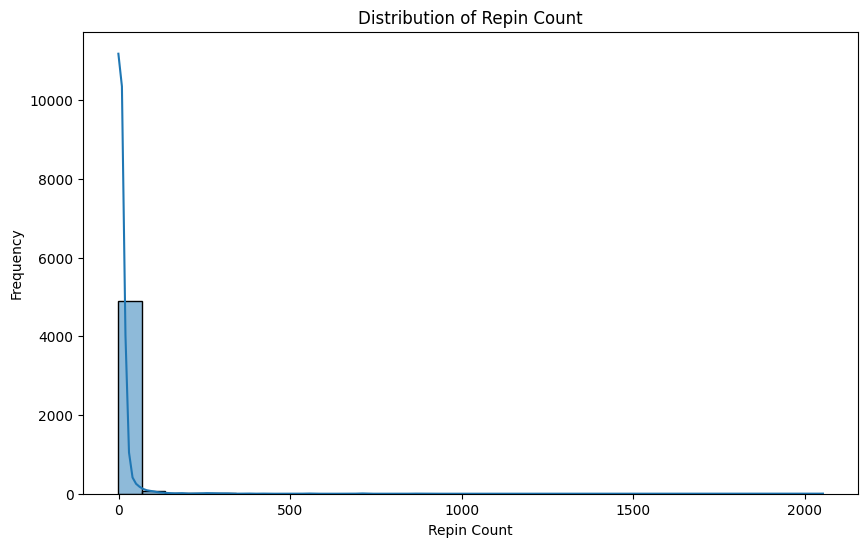

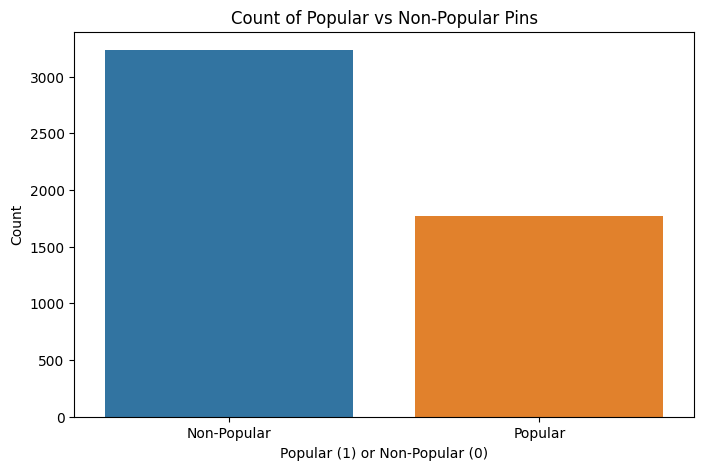

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the distribution of repin_count
plt.figure(figsize=(10, 6))
sns.histplot(df['repin_count'], bins=30, kde=True)
plt.title('Distribution of Repin Count')
plt.xlabel('Repin Count')
plt.ylabel('Frequency')
plt.show()

# Visualize the popularity counts
plt.figure(figsize=(8, 5))
sns.countplot(x='popular', data=df)
plt.title('Count of Popular vs Non-Popular Pins')
plt.xlabel('Popular (1) or Non-Popular (0)')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['Non-Popular', 'Popular'])
plt.show()

**Text Preprocessing**

In [7]:
# Create a new feature by combining 'Description' and 'Title'
df['text'] = df['description'] + ' ' + df['title']
# Text Vectorization Using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

# Set up the TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=1000)

# Fit the TF-IDF vectorizer on the 'text' feature
X_text = tfidf.fit_transform(df['text']).toarray()

# Resulting matrix
print(X_text.shape)

(5000, 1000)


**Train-Test Split**

In [8]:
from sklearn.model_selection import train_test_split

# Features (X) and target (y)
X = X_text
y = df['popular']

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)

Training set size: (4000, 1000)
Test set size: (1000, 1000)


**Model Building**

In [9]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay

**Logistic Regression Model**

In [10]:
# Training Logistic Regression classifier
logistic_model = LogisticRegression(max_iter=1000, random_state=42)
logistic_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_logistic = logistic_model.predict(X_test)

# Evaluate the Logistic Regression model
print("Logistic Regression Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_logistic):.2f}")
print(classification_report(y_test, y_pred_logistic))

Logistic Regression Results:
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.67      0.95      0.78       659
           1       0.45      0.09      0.15       341

    accuracy                           0.65      1000
   macro avg       0.56      0.52      0.46      1000
weighted avg       0.59      0.65      0.57      1000



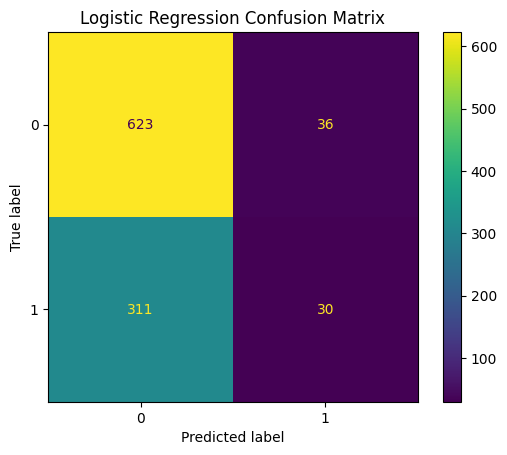

In [11]:
# Confusion matrix for Logistic Regression
cm_logistic = confusion_matrix(y_test, y_pred_logistic)
disp_logistic = ConfusionMatrixDisplay(confusion_matrix=cm_logistic)
disp_logistic.plot()
plt.title('Logistic Regression Confusion Matrix')
plt.show()

**Random Forest Classifier**

In [12]:
# Training Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict the labels for the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
print("\nRandom Forest Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_rf):.2f}")
print(classification_report(y_test, y_pred_rf))


Random Forest Results:
Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.66      0.93      0.78       659
           1       0.41      0.09      0.14       341

    accuracy                           0.65      1000
   macro avg       0.54      0.51      0.46      1000
weighted avg       0.58      0.65      0.56      1000



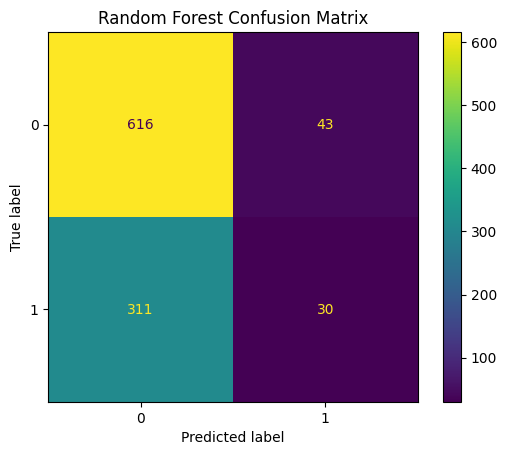

In [13]:
# Confusion matrix for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf)
disp_rf.plot()
plt.title('Random Forest Confusion Matrix')
plt.show()  # Show the plot

**Feature Importance for Random Forest**

          word  importance
347       from    0.025045
856        the    0.013873
40         and    0.012534
877         to    0.010812
430         in    0.010604
438  instagram    0.009983
607         on    0.009605
459        joy    0.008629
338        for    0.008567
601         of    0.008374


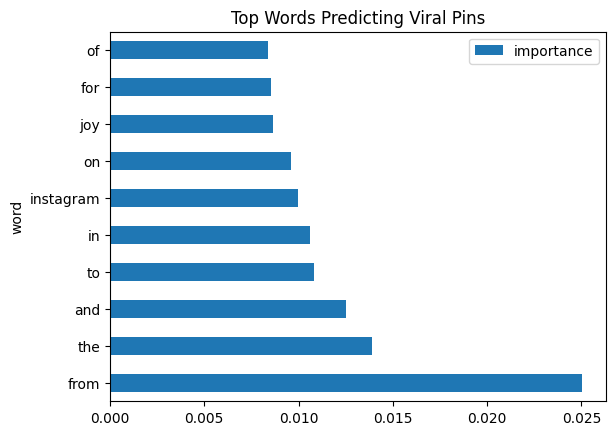

In [14]:
# Get feature importances from the Random Forest model
importances = rf_model.feature_importances_

# Get the names of the words (features)
feature_names = tfidf.get_feature_names_out()

feature_importance_df = pd.DataFrame({'word': feature_names, 'importance': importances})

feature_importance_df = feature_importance_df.sort_values(by='importance', ascending=False)

print(feature_importance_df.head(10))

feature_importance_df.head(10).plot(kind='barh', x='word', y='importance', title='Top Words Predicting Viral Pins')
plt.show()

**Support Vector Machines (SVM)**

SVM Results:
Accuracy: 0.99
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       205
           1       1.00      0.99      1.00       795

    accuracy                           0.99      1000
   macro avg       0.99      1.00      0.99      1000
weighted avg       0.99      0.99      0.99      1000



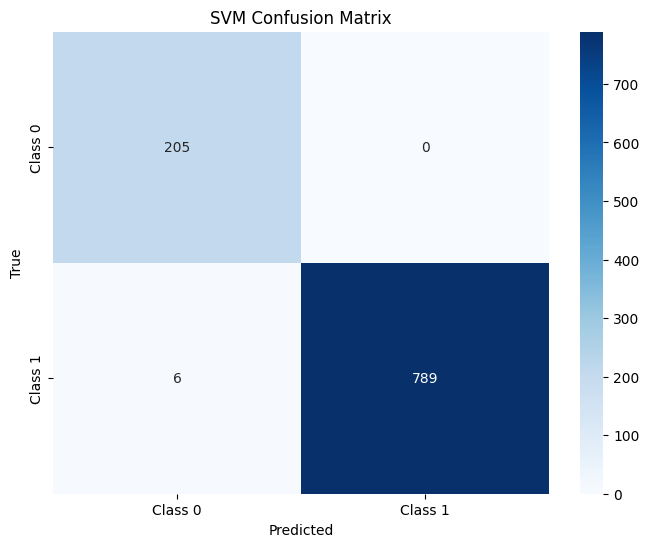

In [15]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Preprocess the data
df['text'] = df['description'].fillna('') + ' ' + df['title'].fillna('')

# Use repin_count as the feature and create a target variable
X = df[['text', 'repin_count']]  
y = df['repin_count'].apply(lambda x: 1 if x > 0 else 0)  

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Text Vectorization using TfidfVectorizer
vectorizer = TfidfVectorizer(max_features=5000)  # You can adjust max_features based on your dataset size
X_train_text = vectorizer.fit_transform(X_train['text'])
X_test_text = vectorizer.transform(X_test['text'])

# Combine vectorized text and repin_count into a single feature set
import scipy
X_train_combined = scipy.sparse.hstack([X_train_text, X_train[['repin_count']].values])
X_test_combined = scipy.sparse.hstack([X_test_text, X_test[['repin_count']].values])

# Apply SMOTE for resampling
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_train_combined, y_train)

# Train
svm_model = SVC(class_weight='balanced', random_state=42)
svm_model.fit(X_resampled, y_resampled)

# Evaluate
y_pred_svm = svm_model.predict(X_test_combined)

print("SVM Results:")
print(f"Accuracy: {accuracy_score(y_test, y_pred_svm):.2f}")
print(classification_report(y_test, y_pred_svm))

# Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Accuracy:

* Random Forest: 0.65
* Logistic Regression: 0.65
* SVM: 0.99

The SVM model significantly outperformed both Random Forest and Logistic Regression in terms of accuracy.

* Best Model: The SVM model is clearly the best performer based on all metrics (accuracy, precision, recall, and F1-score).
* Issues with Other Models: Both Random Forest and Logistic Regression struggled particularly with the positive class (Class 1), indicating they might not be well-suited for this specific problem, possibly due to class imbalance.

**Hyperparameter Tuning for SVM**

In [17]:
# Create a binary target variable based on repin counts
threshold = 50  # Adjust this threshold as needed
df['target'] = (df['repin_count'] > threshold).astype(int)

# Check for NaN values in description and title
print("Checking for NaN values in description and title columns:")
print(df[['description', 'title']].isnull().sum())

# Fill NaN values with empty strings or drop rows with NaN values
df['description'].fillna('', inplace=True)
df['title'].fillna('', inplace=True)

# Split the dataset into features and target
X = df[['description', 'title']]
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text features
tfidf_vectorizer = TfidfVectorizer()
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train['description'] + ' ' + X_train['title'])
X_test_vectorized = tfidf_vectorizer.transform(X_test['description'] + ' ' + X_test['title'])

# Define the SVM model and hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform Grid Search for hyperparameter tuning
svm_grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_vectorized, y_train)

# Output the best parameters and score
print("Best parameters found: ", svm_grid.best_params_)
print("Best cross-validated accuracy: ", svm_grid.best_score_)

# Evaluate the best model on the test set
best_svm_model = svm_grid.best_estimator_
y_pred = best_svm_model.predict(X_test_vectorized)

# Print evaluation metrics
print("SVM Test Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Checking for NaN values in description and title columns:
description    0
title          0
dtype: int64


/tmp/ipykernel_31/3785340648.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['description'].fillna('', inplace=True)
/tmp/ipykernel_31/3785340648.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

NameError: name 'GridSearchCV' is not defined

In [18]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

# Example DataFrame setup (you should replace this with your actual dataset loading code)
# df = pd.read_csv('your_dataset.csv')

# Create a binary target variable based on repin counts
threshold = 50  # Adjust this threshold as needed
df['target'] = (df['repin_count'] > threshold).astype(int)

# Check for NaN values in description and title
print("Checking for NaN values in description and title columns:")
print(df[['description', 'title']].isnull().sum())

# Fill NaN values with empty strings
df.fillna({'description': '', 'title': ''}, inplace=True)

# Split the dataset into features and target
X = df[['description', 'title']]
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text features
tfidf_vectorizer = TfidfVectorizer()
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train['description'] + ' ' + X_train['title'])
X_test_vectorized = tfidf_vectorizer.transform(X_test['description'] + ' ' + X_test['title'])

# Define the SVM model and hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform Grid Search for hyperparameter tuning
svm_grid = GridSearchCV(SVC(), param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_vectorized, y_train)

# Output the best parameters and score
print("Best parameters found: ", svm_grid.best_params_)
print("Best cross-validated accuracy: ", svm_grid.best_score_)

# Evaluate the best model on the test set
best_svm_model = svm_grid.best_estimator_
y_pred = best_svm_model.predict(X_test_vectorized)

# Print evaluation metrics
print("SVM Test Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Checking for NaN values in description and title columns:
description    0
title          0
dtype: int64
Best parameters found:  {'C': 1, 'gamma': 'scale', 'kernel': 'poly'}
Best cross-validated accuracy:  0.9719999340164875
SVM Test Accuracy:  0.967
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       967
           1       0.00      0.00      0.00        33

    accuracy                           0.97      1000
   macro avg       0.48      0.50      0.49      1000
weighted avg       0.94      0.97      0.95      1000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE  

# Create a binary target variable based on repin counts
threshold = 50  
df['target'] = (df['repin_count'] > threshold).astype(int)

# Check for NaN values in description and title
print("Checking for NaN values in description and title columns:")
print(df[['description', 'title']].isnull().sum())

# Fill NaN values with empty strings
df['description'] = df['description'].fillna('')
df['title'] = df['title'].fillna('')

# Split the dataset into features and target
X = df[['description', 'title']]
y = df['target']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text features
tfidf_vectorizer = TfidfVectorizer()
X_train_vectorized = tfidf_vectorizer.fit_transform(X_train['description'] + ' ' + X_train['title'])
X_test_vectorized = tfidf_vectorizer.transform(X_test['description'] + ' ' + X_test['title'])

# Optionally apply SMOTE to address class imbalance
# Uncomment the following lines if you want to use SMOTE
# smote = SMOTE()
# X_train_vectorized, y_train = smote.fit_resample(X_train_vectorized, y_train)

# Define the SVM model and hyperparameter grid
param_grid = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto']
}

# Perform Grid Search for hyperparameter tuning with class weights
svm_grid = GridSearchCV(SVC(class_weight='balanced'), param_grid, cv=3, scoring='accuracy')
svm_grid.fit(X_train_vectorized, y_train)

# Output the best parameters and score
print("Best parameters found: ", svm_grid.best_params_)
print("Best cross-validated accuracy: ", svm_grid.best_score_)

# Evaluate the best model on the test set
best_svm_model = svm_grid.best_estimator_
y_pred = best_svm_model.predict(X_test_vectorized)

# Print evaluation metrics
print("SVM Test Accuracy: ", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Checking for NaN values in description and title columns:
description    0
title          0
dtype: int64
Best parameters found:  {'C': 100, 'gamma': 'auto', 'kernel': 'poly'}
Best cross-validated accuracy:  0.971750058954019
SVM Test Accuracy:  0.033
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       967
           1       0.03      1.00      0.06        33

    accuracy                           0.03      1000
   macro avg       0.02      0.50      0.03      1000
weighted avg       0.00      0.03      0.00      1000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


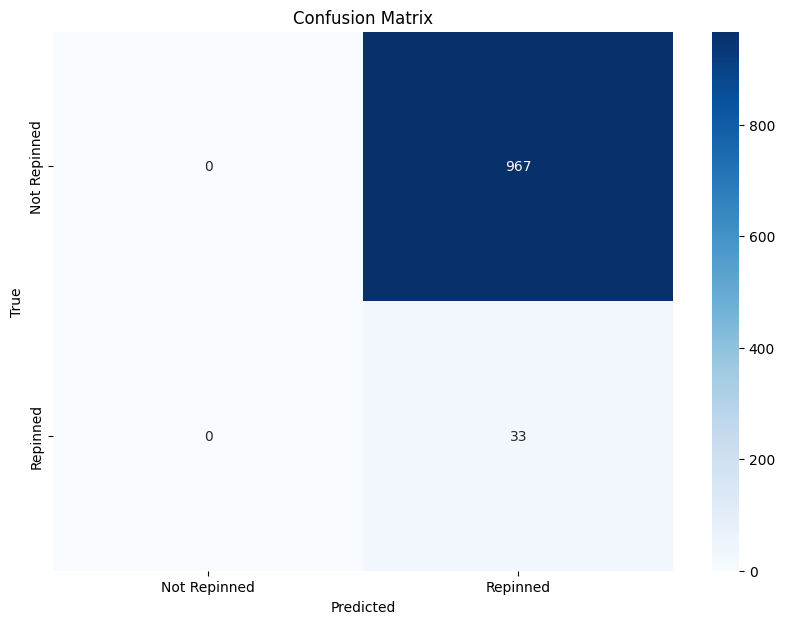

In [20]:
# Generate confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Repinned', 'Repinned'], yticklabels=['Not Repinned', 'Repinned'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

**Cross-Validation**

In [21]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation
cv_scores = cross_val_score(SVC(C=1, kernel='poly', gamma='scale'), X_train_vectorized, y_train, cv=5)
print("Cross-validated accuracy: ", cv_scores.mean())

Cross-validated accuracy:  0.9719999999999999


**Model Saved**

In [22]:
import joblib

# Save the trained model
joblib.dump(best_svm_model, 'svm_model.pkl')

# Save the TF-IDF vectorizer
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']